# featureCounts Compare Exon-Intron Boundaries for non DMS samples: Madrasin Vs Controls

## Purpose

This were read counts generated by the program featureCounts After STAR alignment

Aim of this script is to get the ratio of Madrasin vs Controls in exon-intron boundaries for samples that were not treated with DMS 

We want to see how the ratio changes as you add varying concentrations of Madrasin

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Load R GGplots
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(reshape)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: reshape

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [4]:
# Set variable to remove non-coding genes
removeNC=False
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [5]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [7]:
# which end
whichend=str(5)

In [8]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if ("ExonIntron"+whichend+"p_featureCounts_JustCounts.txt" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        # Read the salmon output file
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        # Sort the data by TPMs
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Mad-20mm-8hr-minus_S11_ExonIntron5p_featureCounts_JustCounts.txt
Mad-30mm-8hr-DMS_S9_ExonIntron5p_featureCounts_JustCounts.txt
Mad-10mm-8hr-minus_S10_ExonIntron5p_featureCounts_JustCounts.txt
Mad-20mm-4hr-minus_S5_ExonIntron5p_featureCounts_JustCounts.txt
Mad-30mm-4hr-minus_S6_ExonIntron5p_featureCounts_JustCounts.txt
Mad-10mm-4hr-minus_S4_ExonIntron5p_featureCounts_JustCounts.txt
All_Minusfiles_ExonIntron5p_featureCounts_JustCounts.txt


In [9]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

64


In [10]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if ("ExonIntron"+whichend+"p_featureCounts_JustCounts_DropHeader.txt" in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        current_columns.append(filename.split("_ExonIntron")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename,header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

All_Minusfiles_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Mad-10mm-4hr-minus_S4_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Mad-30mm-8hr-DMS_S9_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Mad-20mm-4hr-minus_S5_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Mad-10mm-8hr-minus_S10_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Mad-20mm-8hr-minus_S11_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Mad-30mm-4hr-minus_S6_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt


In [11]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(64, 7)


,All_Minusfiles,Mad-10mm-4hr-minus_S4,Mad-30mm-8hr-DMS_S9,Mad-20mm-4hr-minus_S5,Mad-10mm-8hr-minus_S10,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6
ACTB,11258.302270,10312.087439,10493.937446,12435.518831,11750.843813,10262.247498,10864.733944
ACTG1,1789.596499,1283.470634,1962.441405,1989.523099,1770.318886,903.094896,2322.125712
ATP5F1B,2341.946807,2582.445750,3085.860916,2413.146607,2980.652558,2374.995277,2360.039007
B2M,3905.385789,4246.934338,4988.497357,3963.730297,4487.818682,4075.920277,4566.599998
CALR,1815.715342,1748.127757,2054.847357,1979.581894,2175.497471,1776.521666,1910.612602


In [12]:
sorted_columns = sorted(list(feature_readCounts_transcriptome.columns.values))
sorted_columns_NoControl = [i for i in sorted_columns if "All" not in i]

In [13]:
feature_readCounts_transcriptome_MadrasinData = feature_readCounts_transcriptome[sorted_columns_NoControl]
print feature_readCounts_transcriptome_MadrasinData.shape
feature_readCounts_transcriptome_MadrasinData.head()

(64, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,10312.087439,11750.843813,12435.518831,10262.247498,10864.733944,10493.937446
ACTG1,1283.470634,1770.318886,1989.523099,903.094896,2322.125712,1962.441405
ATP5F1B,2582.445750,2980.652558,2413.146607,2374.995277,2360.039007,3085.860916
B2M,4246.934338,4487.818682,3963.730297,4075.920277,4566.599998,4988.497357
CALR,1748.127757,2175.497471,1979.581894,1776.521666,1910.612602,2054.847357


In [14]:
# Let's get ratios of feature counts for Madrasin vs non Madrasin
ratios_readCounts = feature_readCounts_transcriptome_MadrasinData.divide(feature_readCounts_transcriptome["All_Minusfiles"],axis=0)
print ratios_readCounts.shape
ratios_readCounts.head()

(64, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,0.915954,1.043749,1.104564,0.911527,0.965042,0.932107
ACTG1,0.717184,0.989228,1.111716,0.504636,1.297569,1.096583
ATP5F1B,1.102692,1.272724,1.030402,1.014112,1.007725,1.317648
B2M,1.087456,1.149136,1.014939,1.043666,1.169308,1.277338
CALR,0.962776,1.198149,1.090249,0.978414,1.052264,1.131701


In [15]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratios_readCounts.apply(np.mean,axis=0)
ratios_readCounts_avg

Mad-10mm-4hr-minus_S4     0.953517
Mad-10mm-8hr-minus_S10    1.137830
Mad-20mm-4hr-minus_S5     1.078792
Mad-20mm-8hr-minus_S11    0.936310
Mad-30mm-4hr-minus_S6     1.046655
Mad-30mm-8hr-DMS_S9       1.237220
dtype: float64

In [ ]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Median ratio of Madrasin Vs No-Madrasin reads \n around exon-intron boundaries")
plt.savefig("../results/FeatureCounts_MedianRatio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

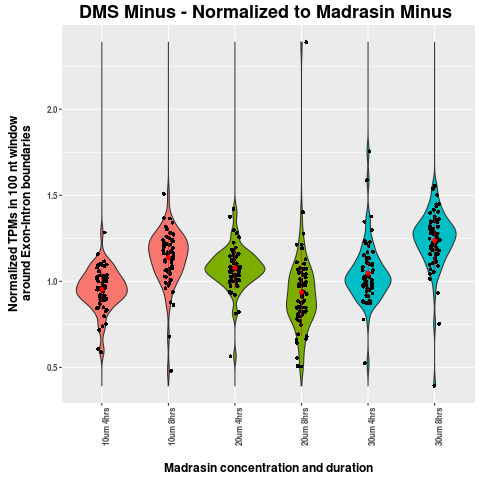

In [81]:
%%R -i ,whichend,numFeatures,removeNC_string,feature,featuresWithIntrons_string
data=ratioratios_readCountss_readCounts
data$ID = row.names(data)
melted_data <- melt(data, id=c("ID"))
#tail(melted_data)
p <- ggplot(melted_data, aes(x=variable, y=value,fill=variable)) +
    #geom_boxplot() + 
    geom_violin(trim=FALSE) +
    geom_jitter(shape=16, position=position_jitter(0.2)) + 
    stat_summary(fun.y = mean,fun.ymin = function(x) mean(x) - sd(x),fun.ymax = function(x) mean(x) + sd(x),geom = "pointrange", size=0.25, color="red") +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(angle = 90, face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         legend.position="none",plot.title = element_text(face="bold",size=18)) + 
    #theme_bw() +
    scale_fill_manual(values=c("#F8766D", "#F8766D","#7CAE00","#7CAE00", "#00BFC4","#00BFC4")) +
    xlab("\nMadrasin concentration and duration") +
    ylab("Normalized TPMs in 100 nt window\n around Exon-Intron boundaries\n") +
    scale_x_discrete(labels=c("10um 4hrs", "10um 8hrs", "20um 4hrs","20um 8hrs","30um 4hrs","30um 8hrs")) +
    ggtitle("DMS Minus - Normalized to Madrasin Minus ")
filenameToSave = paste("../results/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_",whichend,"pExonIntronBoundaries_MinusDMS_",numFeatures,"MostHighlyExpressed",removeNC_string,feature,"s",featuresWithIntrons_string,".png",sep="")
#print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

In [ ]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Average ratio of Madrasin Vs No-Madrasin reads \n around exon-intron boundaries")
plt.savefig("../results/FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

In [ ]:
sns.set(font_scale=2)
ax = sns.clustermap(ratios_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/FeatureCounts_Ratio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [ ]:
labels_indices_org = ratios_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts= ratios_readCounts.reindex(labels_indices_reordered)

In [ ]:
sns.set(font_scale=3.5)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratios_readCounts.values, ax=ax)
plt.savefig("../results/FeatureCounts_Ratio_MadrasinVsNoMadrasin_"+whichend+"pExonIntronBoundaries_MinusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")